#**04 모델 세부 설정**





데이터 정규화까지 처리하여 입력 데이터 준비

In [2]:
import tensorflow as tf

#케라스의 내장 데이터셋에서 mnist 데이터 로드
mnist=tf.keras.datasets.mnist

#load_data()로 데이터 로드
(x_train, y_train), (x_test, y_test)=mnist.load_data()

#로드된 데이터셋 확인
print('train set:', x_train.shape, y_train.shape)
print('test set:', x_test.shape, y_test.shape)

#데이터 정규화
x_train=x_train/x_train.max()
x_test=x_test/x_test.max()

train set: (60000, 28, 28) (60000,)
test set: (10000, 28, 28) (10000,)


##**4-1 초기값 설정**

레이어의 초기화 방법을 다르게 설정할 수 있음
- Dense 레이어는 기본 초기화 방법으로 Uniform 초기화 방법이 설정되어 있음


In [3]:
dense=tf.keras.layers.Dense(256, activation='relu')
dense.get_config()['kernel_initializer']

{'class_name': 'GlorotUniform', 'config': {'seed': None}}

- 초기화 방법을 HeNormal로 변경하기 위해서는 kernel_initializer 매개변수에 설정하면 됨

In [4]:
#문자열 초기화
dense=tf.keras.layers.Dense(256, kernel_initializer='he_normal', activation='relu')
print(dense.get_config()['kernel_initializer'])

#클래스 인스턴스 초기화
he_normal=tf.keras.initializers.HeNormal()
dense=tf.keras.layers.Dense(256, kernel_initializer=he_normal, activation='relu')
print(dense.get_config()['kernel_initializer'])

{'class_name': 'HeNormal', 'config': {'seed': None}}
{'class_name': 'HeNormal', 'config': {'seed': None}}


케라스에서 자주 사용되는 초기화 목록
- `'glorot_normal', 'glorot_uniform'` : 글로럴 초기화(Xavier초기화)
- `'lecun_normal', 'lecun_uniform'` : Yann Lecun 초기화
- `'he_normal','he_uniform'` : He 초기화
- `'random_normal', 'random_uniform'` : 정규 분포, 연속 균등 분포 초기화

##**4-2 규제**
모델의 과대 적합을 해소하기 위해 L1, L2 규제를 적용
- 기본값은 None

In [5]:
#기본값
dense=tf.keras.layers.Dense(256, activation='relu')
dense.get_config()

{'name': 'dense_3',
 'trainable': True,
 'dtype': 'float32',
 'units': 256,
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

모델의 과대적합을 방지하기 위해 모델을 구성하는 레이어마다 규제를 적용 : L1, L2 규제

In [6]:
#L1 규제 적용
dense=tf.keras.layers.Dense(256, kernel_regularizer='l1', activation='relu')
print(dense.get_config()['kernel_regularizer'])

#클래스 인스턴스 적용, alpha=0.1 변경
regularizer=tf.keras.regularizers.l1(l1=0.1)
dense=tf.keras.layers.Dense(256, kernel_regularizer=regularizer, activation='relu')
print(dense.get_config()['kernel_regularizer'])

{'class_name': 'L1', 'config': {'l1': 0.009999999776482582}}
{'class_name': 'L1', 'config': {'l1': 0.10000000149011612}}


##**4-3 드롭아웃**
*2014 'Dropout : A Simple Way to Prevent Neural Networks from Overfitting'*

딥러닝 모델의 층이 넓고 깊어질 때 (wide-and-deep) 모델은 훈련에 주어진 샘플에 과하게 적합하도록 학습하는 경향이 있다. 드롭아웃은 과대적합을 해결하기 위해 제안된 아이디어이며 상당히 좋은 효과를 보인다.

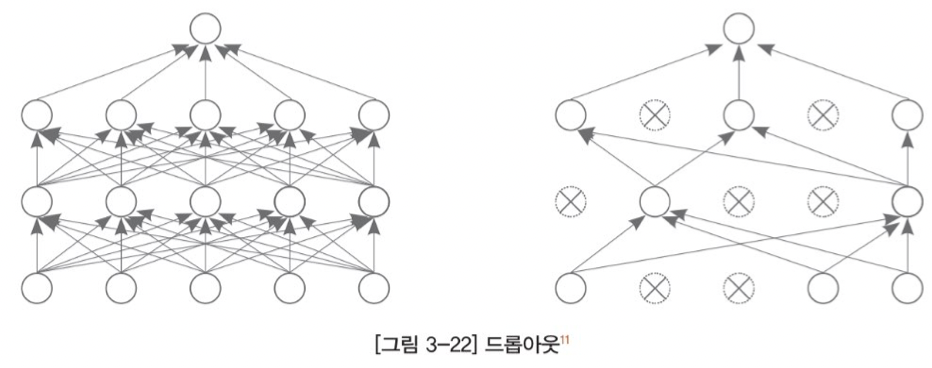

노드의 일부 신호를 임의로 삭제하여 모델이 학습하는 가중치 파라미터의 개수를 줄임
- 모델이 훈련할 때는 드롭아웃이 적용되어 노드 중 일부만 훈련하게 되지만, 예측 시점에서는 모든 노드들이 활용됨

In [7]:
#dropout 25% 비율 적용 (25% 노드가 삭제)
tf.keras.layers.Dropout(0.25)

##**4-4 배치 정규화(Batch Normalization)**
2015 Sergey Ioffe & Christian Szegedy

**배치 정규화** : 각 층에서 활성화 함수를 통과하기 전 미니 배치의 스케일을 정규화한다.
- 다음 층으로 데이터가 전달되기 전에 스케일을 조정하여 보다 안정적인 훈련이 가능하고 성능을 향상시킬 수 있음
- 케라스에서 클래스 함수로 지원하므로 별도 코드 구현이 필요없다. 클래스 인스턴스를 생성해서 추가해주면 됨



In [8]:
#model A: Dense+ReLu
model_a=tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_a.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                50240     
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 10)                330       
                                                                 
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


In [9]:
#model B: Dense+BatchNorm+ReLU
model_b=tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(64),
    #여기서 배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    #배치 정규화 후 활성화 함수 적용
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dense(32),
    #배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    #배치 정규화 후 활성화 함수 적용
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dense(10, activation='softmax')
])

model_b.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                50240     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                      

동일한 조건에서 10번의 epoch 동안 model_a, model_b 두 모델을 훈련할 결과는 다음과 같다.

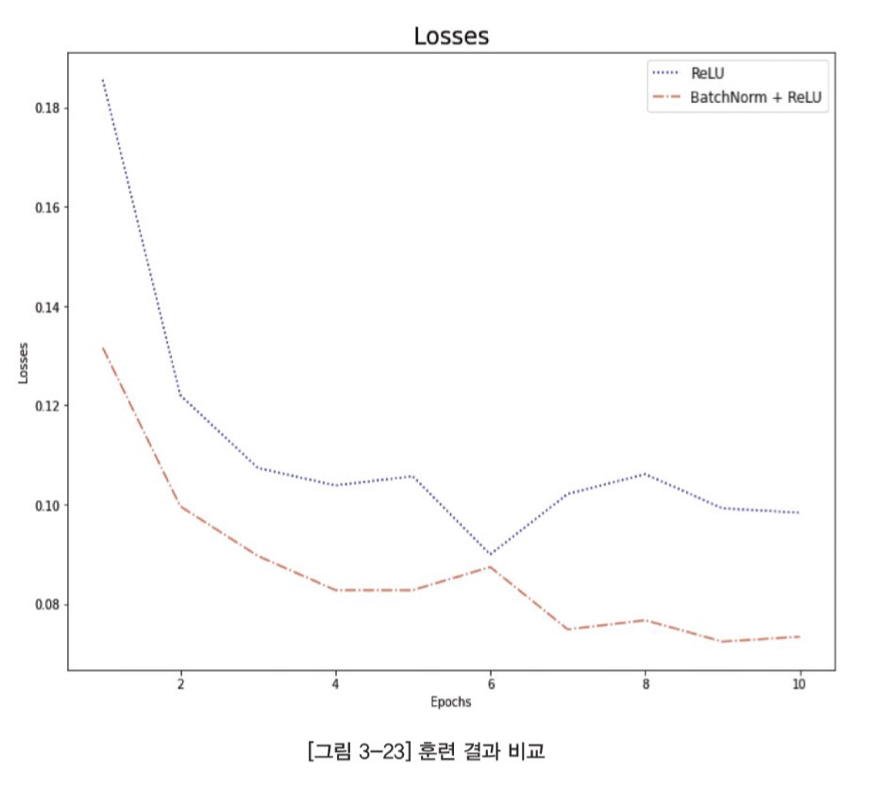

배치 정규화만 추가하였는데 손실은 더 안정적이고 빠르게 수렴하는 것을 확인할 수 있음

##**4-5 활성화함수**
지금까지는 Dense 레이어에 ReLU 활성화 함수를 지정

- 활성화 함수를 적용할 때 다음과 같이 클래스 인스턴스로 선언하여 하이퍼파라미터 값을 변경하여 적용 가능

In [10]:
#LeakyReLU 기본 설정
tf.keras.layers.LeakyReLU()

#LeakyReLU, alpha=0.2로 변경
tf.keras.layers.LeakyReLU(alpha=0.2)

- 모델에 적용

In [11]:
#model C: Dense+BatchNorm+LeakyReLU(0,2)
model_c=tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(64),
    #여기서 배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    #배치 정규화 후 활성화 함수 (LeakyReLU, alpha=0.2) 적용
    tf.keras.layers.LeakyReLU(alpha=0.2),

    tf.keras.layers.Dense(32),
    #배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    #배치 정규화 후 활성화 함수 적용
    tf.keras.layers.LeakyReLU(alpha=0.2),

    tf.keras.layers.Dense(10, activation='softmax')
])

model_c.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                50240     
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_3 (Batc  (None, 32)               128       
 hNormalization)                                      

3개의 모델을 동일한 조건으로 10번의 epoch 동안 훈련한 후에 수렴 속도를 확인
- **model_a** : Dense 레이어 + ReLU 활성화 함수
- **model_b** : Dense 레이어 + 배치 정규화
- **model_c** : Dense 레이어 + 배치 정규화 + LeakyReLU(0.2) 활성화함수

In [12]:
model_a.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_b.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_c.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Model A : Dense + ReLU
history_a=model_a.fit(x_train, y_train,
                      validation_data=(x_test, y_test), epochs=10)
#Model B : Dense + BatchNorm + ReLU
history_b=model_b.fit(x_train, y_train,
                      validation_data=(x_test, y_test), epochs=10)
#Model C : Dense + BatchNorm + LeakyReLU(0,2)
history_c=model_c.fit(x_train, y_train,
                      validation_data=(x_test, y_test), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2995 - accuracy: 0.9133 - val_loss: 0.1528 - val_accuracy: 0.9534
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1383 - accuracy: 0.9586 - val_loss: 0.1250 - val_accuracy: 0.9617
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0993 - accuracy: 0.9698 - val_loss: 0.1023 - val_accuracy: 0.9688
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0782 - accuracy: 0.9762 - val_loss: 0.1079 - val_accuracy: 0.9674
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0663 - accuracy: 0.9791 - val_loss: 0.0893 - val_accuracy: 0.9727
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0549 - accuracy: 0.9818 - val_loss: 0.0963 - val_accuracy: 0.9709
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0451 - accuracy: 0.9856 - val_loss: 0.0958 - val_accuracy:

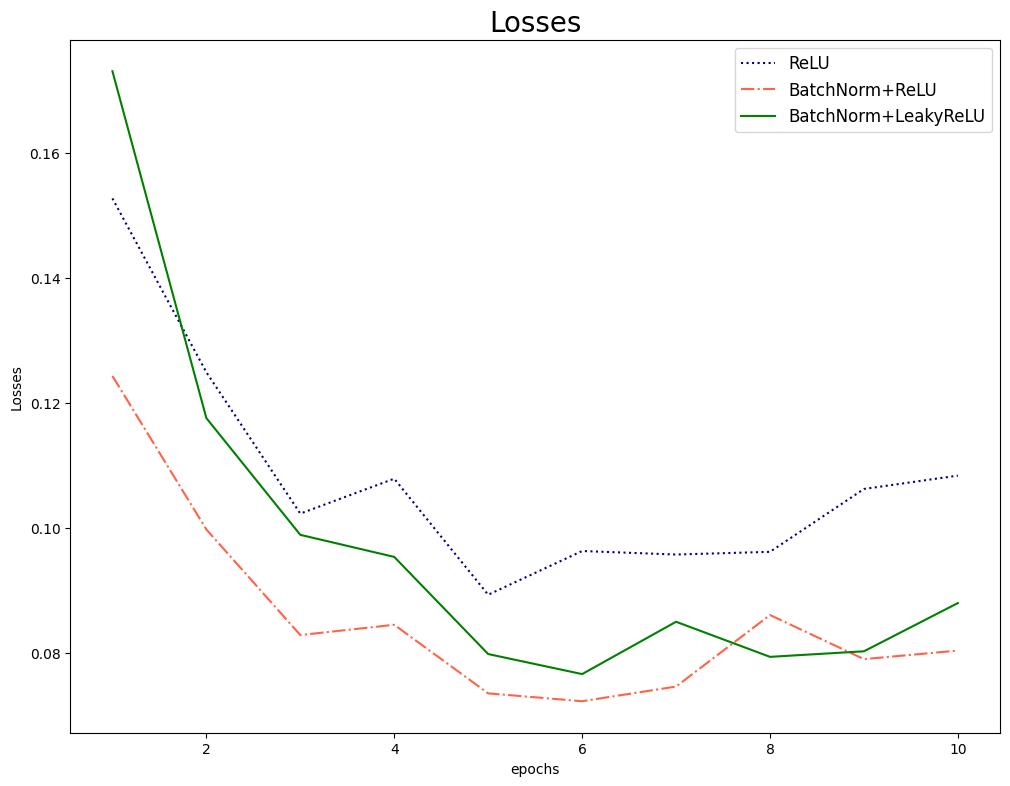

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, 11), history_a.history['val_loss'], color='navy', linestyle=':')
plt.plot(np.arange(1, 11), history_b.history['val_loss'], color='tomato', linestyle='-.')
plt.plot(np.arange(1, 11), history_c.history['val_loss'], color='green', linestyle='-')

plt.title('Losses', fontsize=20)
plt.xlabel('epochs')
plt.ylabel('Losses')
plt.legend(['ReLU', 'BatchNorm+ReLU', 'BatchNorm+LeakyReLU'], fontsize=12)
plt.show()

- mnist 데이터셋은 모델별 차이가 크지는 않다.
- 복잡한 데이터셋을 다룬다면 배치 정규화와 다른 활성화 함수를 적용해보며 모델의 훈련 추이를 관찰해 볼 필요가 있다.

#**06 모델 저장 및 불러오기**

##**6-1 모델을 파일로 저장**

`save()` : 훈련을 종료하여 가중치가 업데이트된 모델 인스턴스를 저장
- 형식은 HDF5, SavedModel 포맷 두가지
- .h5 확장자를 포함하는 경우는 모델이 HDF5(Hierarchical Data Format)으로 저장 : 대용량의 데이터를 저장하기 위한 파일 형식

In [30]:
#모델명을 h5 포맷으로 저장
model_c.save('h5-model.h5')

##**6-2 저장된 모델 복원**

`tensorflow.keras.models.load_model()` : 저장된 모델 복원

In [31]:
#모델 복원
h5_model=tf.keras.models.load_model('h5-model.h5')
h5_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                50240     
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_3 (Batc  (None, 32)               128       
 hNormalization)                                      

In [32]:
#모델 검증
loss, acc=h5_model.evaluate(x_test, y_test, verbose=0)
print(f'h5_model] loss: {loss:.5f}, acc: {acc:.5f}')

h5_model] loss: 0.08799, acc: 0.97600


In [33]:
#모델을 SavedModel 포맷으로 저장
model_c.save('saved-model')

In [34]:
#모델 복원
saved_model=tf.keras.models.load_model('saved-model')
saved_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                50240     
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_3 (Batc  (None, 32)               128       
 hNormalization)                                      

In [35]:
#모델 검증 (HDF5 포맷)
loss, acc=h5_model.evaluate(x_test, y_test, verbose=0)
print(f'h5_model] loss: {loss:.5f}, acc: {acc:.5f}')

#모델 검증 (SavedModel 포맷)
loss, acc=saved_model.evaluate(x_test, y_test, verbose= 0)
print(f'saved_model] loss: {loss:.5f}, acc: {acc:.5f}')

h5_model] loss: 0.08799, acc: 0.97600
saved_model] loss: 0.08799, acc: 0.97600


#**07 복잡한 모델 생성**

##**7-1 함수형 API(Functional API)**

함수 형태로 딥러닝 모델을 정의하면 다양한 모델 구조를 구현할 수 있음

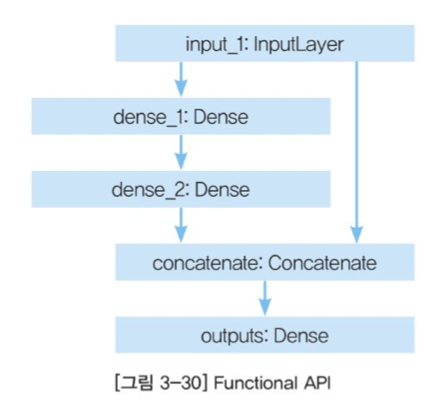

함수의 입력 매개변수를 여러 개 갖는 **다중 입력**, 함수의 return 값을 여러 개 갖는 **다중 출력**, 같은 레벨에 여러 개의 층을 배치하여 입력과 출력을 공유하는 구조도 가능

함수형 API 
- Input 레이어를 정의(데이터의 입력 shape)
- 레이어마다 반환되는 출력 값을 변수에 저장한 뒤 다음 레이어의 입력으로 연결 : 체인구조

In [20]:
import tensorflow as tf

#모델의 레이어를 체인 구조로 연결 input 레이어 정의
input_layer=tf.keras.Input(shape=(28, 28), name='InputLayer')

#모델의 레이어를 체인 구조로 연결
x1=tf.keras.layers.Flatten(name='Flatten')(input_layer)
x2=tf.keras.layers.Dense(256, activation='relu', name='Dense1')(x1)
x3=tf.keras.layers.Dense(64, activation='relu', name='Dense2')(x2)
x4=tf.keras.layers.Dense(10, activation='softmax', name='OutputLayer')(x3)

레이어마다 name 매개변수로 이름을 부여할 수 있음 -> summary()로 요약 출력할 때 이름이 같이 출력됨

체인 방식으로 연결한 후 `tf.keras.Model()`에 입력 레이어와 출력 레이어를 정의해 모델 생성

In [21]:
#모델 생성
func_model=tf.keras.Model(inputs=input_layer, outputs=x4, name='FunctionalModel')

#모델 요약
func_model.summary()

Model: "FunctionalModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28)]          0         
                                                                 
 Flatten (Flatten)           (None, 784)               0         
                                                                 
 Dense1 (Dense)              (None, 256)               200960    
                                                                 
 Dense2 (Dense)              (None, 64)                16448     
                                                                 
 OutputLayer (Dense)         (None, 10)                650       
                                                                 
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
_________________________________________________________________


inputs : input_layer, outputs : 출력층

- `plot_model` 모듈을 활용해 구조도 시각화
  - `show_shapes = True` : 데이터의 입출력 shape 출력
  - `show_layer_names = True` : 레이어의 이름 출력
  - to_file 매개변수에 파일명 입력하면 이미지 파일로 저장 가능

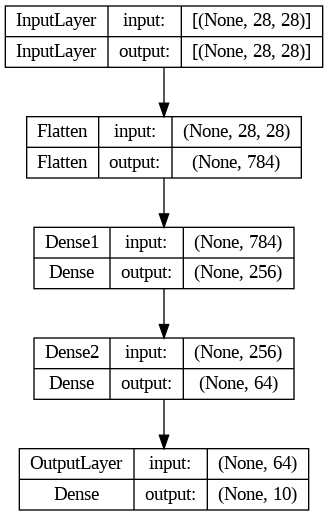

In [22]:
from tensorflow.keras.utils import plot_model

#구조도 시각화
plot_model(func_model, show_shapes=True, show_layer_names=True, to_file='model.png')

함수형 API로 생성한 모델도 Sequantial API로 생성한 모델과 동일한 방식으로 훈련 가능

In [23]:
#컴파일
func_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#훈련
func_model.fit(x_train, y_train, epochs=3)

#검증
loss, acc=func_model.evaluate(x_test, y_test, verbose=0)
print(f'Functional Model] loss: {loss:.5f}, acc: {acc:.5f}')

Epoch 1/3
1875/1875 [==============================] - 13s 6ms/step - loss: 0.2129 - accuracy: 0.9375
Epoch 2/3
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0857 - accuracy: 0.9738
Epoch 3/3
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0590 - accuracy: 0.9811
Functional Model] loss: 0.07188, acc: 0.97810


##**7-2 모델 서브클래싱(Model Subclassing)**
케라스는 Model 클래스를 제공하고, 이를 기반으로 딥러닝 모델을 구현하고 있다. 이 클래스를 직접 상속받아 사용자가 직접 서브클래스로 딥러닝 모델을 만들 수도 있다.

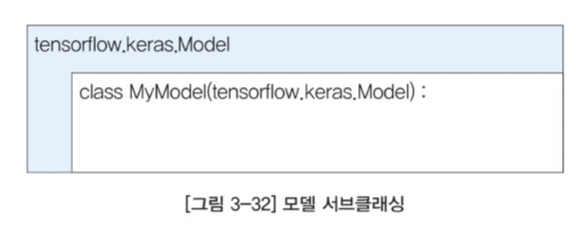

함수형 API로 생성한 모델과의 성능 차이는 없다. 클래스의 개념을 잘 이해하고 있다면 좋은 방법

tf.keras.Model을 상속받아 생성하고자 하는 모델 클래스를 구현

In [24]:
class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    #초기값 설정
    self.flatten=tf.keras.layers.Flatten()
    self.dense1=tf.keras.layers.Dense(256, activation='relu')
    self.dense2=tf.keras.layers.Dense(64, activation='relu')
    self.dense3=tf.keras.layers.Dense(10, activation='softmax')

  #method overiding
  #훈련용 함수 정의
  #x는 input
  def call(self, x):
    x=self.flatten(x)
    x=self.dense1(x)
    x=self.dense2(x)
    x=self.dense3(x)
    return x

call() 함수를 메소드 오버라이딩으로 구현
- `call()` : fit() 메소드가 호출되어 훈련하는 경우 호출될 함수
- 함수 내부에서는 모델의 입력부터 출력까지의 흐름, 즉 순전파(forward propagation)을 정의하고 함수형 API와 같은 방식으로 모든 레이어를 체인처럼 연결


In [25]:
#모델 생성
mymodel=MyModel()

#모델의 이름 설정
mymodel._name='subclass_model'

#모델 input 정의
mymodel(tf.keras.layers.Input(shape=(28, 28)))

#모델 요약
mymodel.summary()

Model: "subclass_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_15 (Dense)            multiple                  200960    
                                                                 
 dense_16 (Dense)            multiple                  16448     
                                                                 
 dense_17 (Dense)            multiple                  650       
                                                                 
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
_________________________________________________________________


- input_shape이 정의되지 않았기 때문에 전체 모델의 구조를 바로 출력할 수 없음
- mymodel에 Input 레이어와 함께 shape 정의해주면 summary()로 모델의 요약 확인 가능

In [26]:
#컴파일
mymodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#훈련
mymodel.fit(x_train, y_train, epochs=3)

#검증
loss, acc=mymodel.evaluate(x_test, y_test, verbose=0)
print(f'Subclassing Model] loss: {loss:.5f}, acc: {acc:.5f}')

Epoch 1/3
1875/1875 [==============================] - 13s 6ms/step - loss: 0.2126 - accuracy: 0.9369
Epoch 2/3
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0885 - accuracy: 0.9726
Epoch 3/3
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0608 - accuracy: 0.9808
Subclassing Model] loss: 0.08213, acc: 0.97390


##**7-3 서브클래싱 모델 파라미터를 활용한 생성**
Model Subclassing으로 생성하는 장점 : 생성자 파라미터로 모델 내부 레이어의 하이퍼파라미터를 지정할 수 있다.

- 모델의 생성자 파라미터를 추가하여 동적으로 레이어의 유닛 개수를 초기화하는 예제

In [27]:
class MyModel(tf.keras.Model):

  #생성자 파라미터 추가
  def __init__(self, units, num_classes):
    super(MyModel, self).__init__()
    #초기값 설정
    self.flatten=tf.keras.layers.Flatten()
    self.dense1=tf.keras.layers.Dense(units, activation='relu')
    self.dense2=tf.keras.layers.Dense(units/4, activation='relu')
    self.dense3=tf.keras.layers.Dense(num_classes, activation='softmax')

  #class overiding
  #훈련용 함수 정의
  #x는 input
  def call(self, x):
    x=self.flatten(x)
    x=self.dense1(x)
    x=self.dense2(x)
    x=self.dense3(x)
    return x

모델의 생성자 파라미터로 기준이 되는 unit의 개수를 입력받아 Dense 레이어의 유닛 개수를 계산하여 설정

In [28]:
#모델 생성
mymodel=MyModel(256, 10)

#모델 input 정의
mymodel(tf.keras.layers.Input(shape=(28, 28)))

#모델 요약
mymodel.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         multiple                  0         
                                                                 
 dense_18 (Dense)            multiple                  200960    
                                                                 
 dense_19 (Dense)            multiple                  16448     
                                                                 
 dense_20 (Dense)            multiple                  650       
                                                                 
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
_________________________________________________________________


In [29]:
#컴파일
mymodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#훈련
mymodel.fit(x_train, y_train, epochs=3)

#검증
loss, acc=mymodel.evaluate(x_test, y_test, verbose=0)
print(f'Subclassing Model w.parameters] loss: {loss:.5f}, acc: {acc:.5f}')

Epoch 1/3
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2115 - accuracy: 0.9373
Epoch 2/3
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0880 - accuracy: 0.9724
Epoch 3/3
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0607 - accuracy: 0.9808
Subclassing Model w.parameters] loss: 0.08216, acc: 0.97420
